In [1]:
import numpy as np
from collections import Counter
import os
import pickle
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
os.chdir('C:\\Users\\ning\\OneDrive\\python works\\modification-pipelines')
import eegPinelineDesign
results = pickle.load(open('sleep annotation.p','rb'))
temp=[]
for name in results.keys():
    sub=results[name]
    result=sub['result']
    temp.append(result['my ASI'])

In [2]:
temp=np.concatenate(temp)

In [3]:
Ncat=6

In [4]:
_,bins=pd.cut(temp,Ncat,labels=False,retbins=True)

transisition matrix

 suj13_nap_day2 

 [[ 0.89473684  0.05263158  0.05263158]
 [ 0.          0.875       0.125     ]
 [ 0.02197802  0.          0.97802198]]
0.021978021978
0.0
0.978021978022
0.0
0.875
0.125
0.894736842105
0.0526315789474
0.0526315789474
emissin matrix

 suj13_nap_day2 

 [[ 0.04166667  0.66666667  0.29166667  0.          0.          0.        ]
 [ 0.36263736  0.50549451  0.0952381   0.          0.          0.03663004]
 [ 0.13559322  0.62711864  0.22033898  0.01694915  0.          0.        ]]
transisition matrix

 suj29_nap_day1_edited 

 [[ 0.92857143  0.07142857  0.          0.        ]
 [ 0.          0.95238095  0.04761905  0.        ]
 [ 0.          0.          0.98591549  0.01408451]
 [ 0.          0.          0.          1.        ]]
0.0
0.0
0.0
1.0
0.0
0.0
0.985915492958
0.0140845070423
0.0
0.952380952381
0.047619047619
0.0
0.928571428571
0.0714285714286
0.0
0.0
emissin matrix

 suj29_nap_day1_edited 

 [[ 0.49206349  0.3015873   0.          0.          0.     

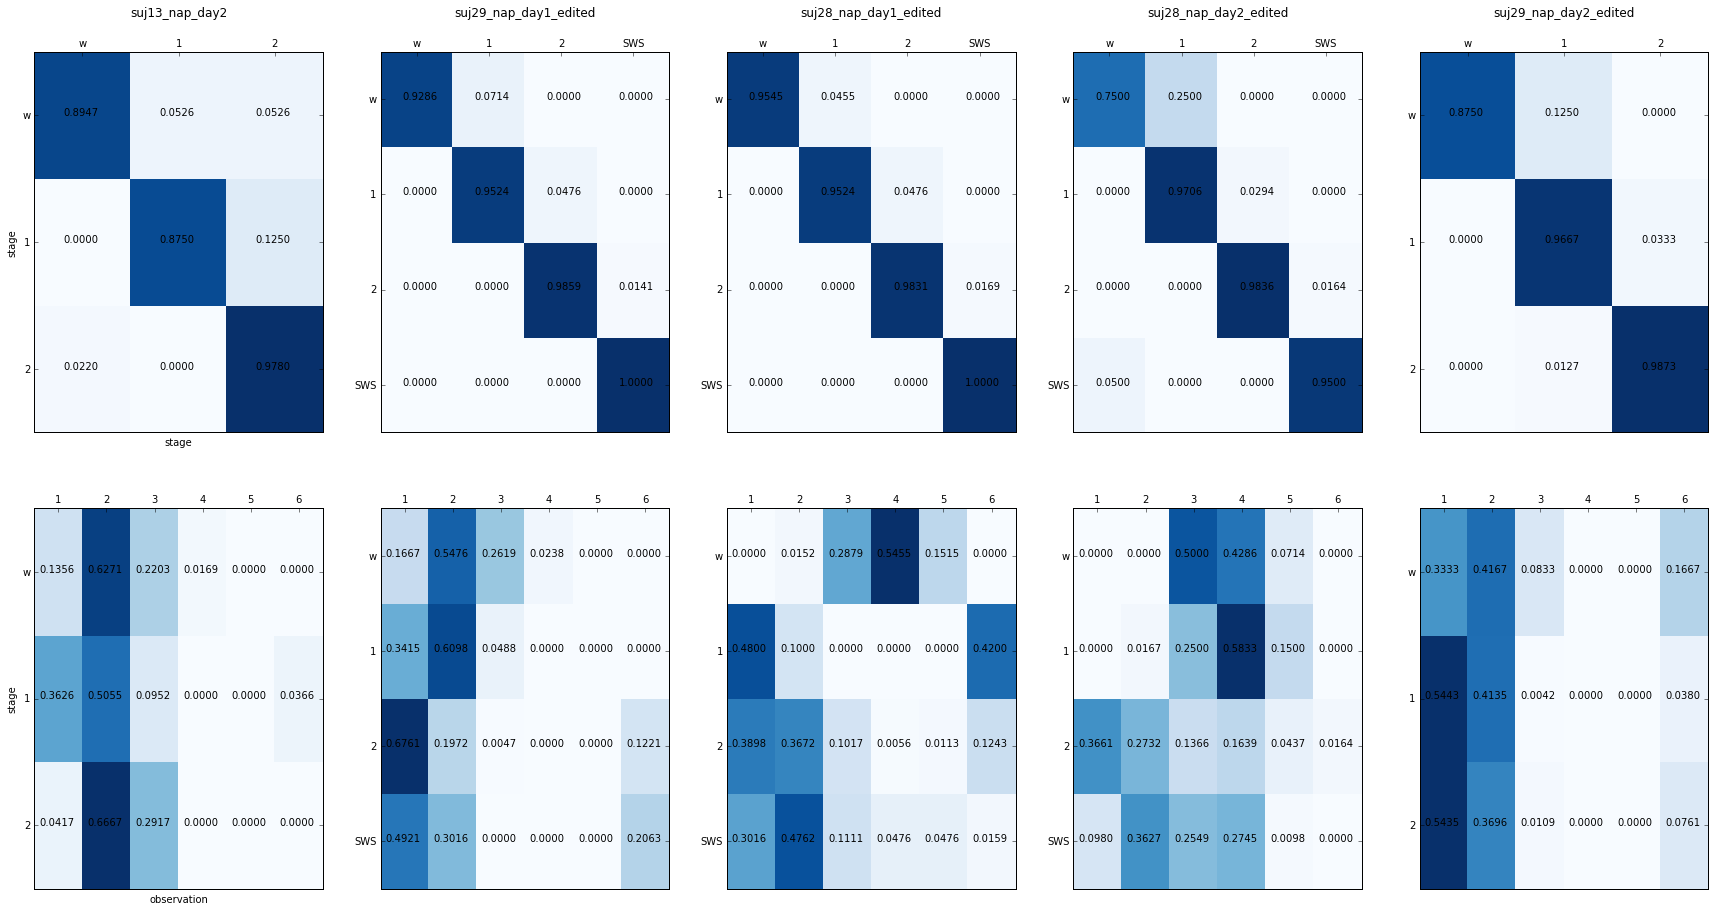

In [6]:
fig=plt.figure(figsize=(30,15));cnt=1
for name in results.keys():
    sub=results[name]
    annotation=sub['annotation']
    key=re.compile('Marker',re.IGNORECASE)
    temp=[]
    for row in enumerate(annotation.iterrows()):
        #print(row[1][-1])
        if key.search(row[1][-1][-1]):
            temp.append([row[1][-1][-2],row[1][-1][-1]])
    temp = pd.DataFrame(temp,columns=['Onset','annotation'])
    
    temp['annotation']=temp.annotation.apply(eegPinelineDesign.recode_annotation)
    #ax=temp.plot(x='Onset',y='annotation',style='.-',yticks=[0,1,2,3],xticks=temp.Onset.values[::10])
    #_=ax.set(yticklabels=['w','1','2','SWS'],title=name,xlabel='time (sec)',ylabel='stage',
    #         xlim=(-2,1900))
    a=temp['annotation'].values
    state = np.vstack((a,a,a))
    state = state.T.reshape((3*len(a)))
    state = state[:-1]
    Nstate=len(np.unique(temp['annotation'].values))
    if Nstate == 4:
        yticklabels=['SWS','2','1','w']
    else:
        yticklabels=['2','1','w']
    tranMat = np.zeros((Nstate,Nstate))
    for (x,y), c in Counter(zip(a, a[1:])).items():
        tranMat[x][y] = c
    tranMat = tranMat / tranMat.sum(axis=1, keepdims=True)
    print('transisition matrix\n\n',name,'\n\n', tranMat)
    ax1=fig.add_subplot(2,5,cnt)
    ax1.pcolor(np.flipud(tranMat),cmap=plt.cm.Blues)
    ax1.xaxis.tick_top()
    ax1.set(xticks=np.arange(Nstate)+0.5,yticks=np.arange(Nstate)+0.5,
            xticklabels=['w','1','2','SWS'],yticklabels=yticklabels)
    plt.title(name,y=1.08)
    for x in range(tranMat.shape[0]):
        for y in range(tranMat.shape[1]):
            print(np.flipud(tranMat)[x,y])
            ax1.annotate('%.4f'%np.fliplr(tranMat.T)[x,y],xy=(x+0.3,y+0.5))
    if cnt == 1:
        ax1.set(xlabel='stage',ylabel='stage')
    
    
    Obs = results[name]['result']['my ASI']
    Obs = pd.DataFrame({'Obs':pd.cut(Obs,bins,labels=False)})
    #ax=Obs.plot(style='.-',yticks=np.arange(Ncat))
    #_=ax.set(title=name,yticklabels=np.arange(Ncat)+1)
    EmissionMat = np.zeros((Nstate,Ncat))
    for (x,y),c in Counter(zip(state,Obs['Obs'].values)).items():
        EmissionMat[x-1][y-1] = c
    EmissionMat = EmissionMat / EmissionMat.sum(axis=1, keepdims=True)
    print('emissin matrix\n\n',name,'\n\n',EmissionMat)
    ax2=fig.add_subplot(2,5,cnt+5)
    ax2.pcolor(EmissionMat,cmap=plt.cm.Blues)
    ax2.xaxis.tick_top()
    ax2.set(yticks=np.arange(Nstate)+0.5,xticks=np.arange(Ncat)+0.5,
            yticklabels=yticklabels,xticklabels=np.arange(Ncat)+1)
    for x in range(EmissionMat.shape[0]):
        for y in range(EmissionMat.shape[1]):
            ax2.annotate('%.4f'%EmissionMat[x,y],xy=(y+0.1,x+0.5))
    if cnt == 1:
        ax2.set(xlabel='observation',ylabel='stage')
    cnt +=1

from yahmm import *
model = Model(name='sleep')

# define distribution for observation categories
Unique_obs = DiscreteDistribution({str(i): 1/Ncat for i in np.arange(Ncat)+1})
Unique_obs

# create the insert states (stages?)
i0 = State(Unique_obs,name="I0")
i1 = State(Unique_obs,name="I1")
i2 = State(Unique_obs,name="I2")
i3 = State(Unique_obs,name="I3")
i4 = State(Unique_obs,name="I4")
i5 = State(Unique_obs,name="I5")

EmissionMat

# create the match states
m0 = State(DiscreteDistribution({str(i):v for i,v in zip(np.arange(Ncat),EmissionMat[0,:])}))
m1 = State(DiscreteDistribution({str(i):v for i,v in zip(np.arange(Ncat),EmissionMat[1,:])}))
m2 = State(DiscreteDistribution({str(i):v for i,v in zip(np.arange(Ncat),EmissionMat[2,:])}))
m3 = State(DiscreteDistribution({str(i):v for i,v in zip(np.arange(Ncat),EmissionMat[3,:])}))

# add all the states to the model
model.add_states([i0,i1,i2,i3,i4,i5,m0,m1,m2,m3])

# transition for match states
model.add_transitions(m0,[m0,m1,m2,m3],tranMat[0,:])
model.add_transitions(m1,[m0,m1,m2,m3],tranMat[1,:])
model.add_transitions(m2,[m0,m1,m2,m3],tranMat[2,:])
model.add_transitions(m3,[m0,m1,m2,m3],tranMat[3,:])

# emission matrix
model.add_transitions(m0,[i0,i1,i2,i3,i4,i5],EmissionMat[0,:])
model.add_transitions(m1,[i0,i1,i2,i3,i4,i5],EmissionMat[1,:])
model.add_transitions(m2,[i0,i1,i2,i3,i4,i5],EmissionMat[2,:])
model.add_transitions(m3,[i0,i1,i2,i3,i4,i5],EmissionMat[3,:])

model.bake()

In [7]:
from hmmlearn import hmm

In [34]:
X = np.column_stack([Obs['Obs'].values[:len(state)],state])

In [38]:
model = hmm.GaussianHMM(n_components=4,covariance_type='diag',n_iter=1000).fit(X)

In [39]:
hidden_states = model.predict(X)

In [42]:
for ii in range(model.n_components):
    print('%dth hidden state'%ii)
    print('mean = ', model.means_[ii])
    print('var =  ', np.diag(model.covars_[ii]))

0th hidden state
mean =  [ 2.  2.]
var =   [ 0.00010204  0.00010204]
1th hidden state
mean =  [ 0.93487553  2.        ]
var =   [  6.09643285e-02   7.24703067e-05]
2th hidden state
mean =  [ 0.84785426  0.82630685]
var =   [ 0.14211326  0.14404363]
3th hidden state
mean =  [ 2.08325834  0.77035616]
var =   [ 0.07812969  0.21914639]


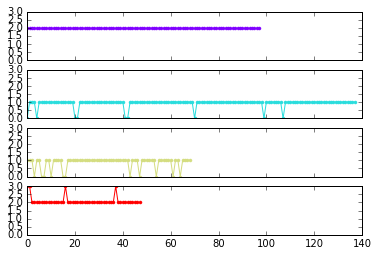

In [43]:
fig,axs = plt.subplots(model.n_components,sharex=True,sharey=True)
colours = plt.cm.rainbow(np.linspace(0,1,model.n_components))
for ii, (ax,colour) in enumerate(zip(axs,colours)):
    mask = hidden_states == ii
    ax.plot(Obs['Obs'].values[:len(state)][mask],'.-',c=colour)